In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy pandas scikit-learn matplotlib seaborn lifelines pycox torchtuples --quiet
!pip install torch --quiet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv


In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")
df = df.drop(columns=['partial_hazard'], errors='ignore')

# Features and targets
feature_names = [c for c in df.columns if c not in ['time','event']]
X = df[feature_names].values.astype('float32')
times = df['time'].values.astype('float32')
events = df['event'].values.astype('int32')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp).astype('float32')

# Train/val/test split
X_train, X_temp, t_train, t_temp, e_train, e_temp = train_test_split(
    X_scaled, times, events, test_size=0.3, random_state=42, stratify=events
)
X_val, X_test, t_val, t_test, e_val, e_test = train_test_split(
    X_temp, t_temp, e_temp, test_size=0.5, random_state=42, stratify=e_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (840, 6) Val: (180, 6) Test: (180, 6)


In [4]:
# ============================================
# Cell 3 — Define & Train DeepSurv (fixed)
# ============================================
import torchtuples as tt
from pycox.models import CoxPH

# Network architecture
in_features = X_train.shape[1]
num_nodes = [64, 32]
out_features = 1
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features,
                              batch_norm=True, dropout=0.1)

# CoxPH model
model = CoxPH(net, torch.optim.Adam)
model.optimizer.set_lr(1e-3)

# Fit model — IMPORTANT: pass (durations, events) as a tuple
log = model.fit(
    X_train,
    (t_train, e_train),   # <-- fixed here
    batch_size=32,
    epochs=100,
    val_data=(X_val, (t_val, e_val)),  # validation also as tuple
    verbose=True
)

# Compute baseline hazards
model.compute_baseline_hazards()

0:	[0s / 0s],		train_loss: 2.6375,	val_loss: 4.0641
1:	[0s / 0s],		train_loss: 2.5926,	val_loss: 4.0432
2:	[0s / 0s],		train_loss: 2.5552,	val_loss: 4.0362
3:	[0s / 0s],		train_loss: 2.5196,	val_loss: 4.0334
4:	[0s / 0s],		train_loss: 2.5353,	val_loss: 4.0219
5:	[0s / 0s],		train_loss: 2.5144,	val_loss: 4.0203
6:	[0s / 0s],		train_loss: 2.4870,	val_loss: 4.0160
7:	[0s / 0s],		train_loss: 2.5199,	val_loss: 4.0263
8:	[0s / 0s],		train_loss: 2.5335,	val_loss: 4.0302
9:	[0s / 0s],		train_loss: 2.5145,	val_loss: 4.0183
10:	[0s / 0s],		train_loss: 2.4762,	val_loss: 4.0152
11:	[0s / 0s],		train_loss: 2.4754,	val_loss: 4.0148
12:	[0s / 1s],		train_loss: 2.4697,	val_loss: 4.0023
13:	[0s / 1s],	
14:	[0s / 1s],	
15:	[0s / 1s],	
16:	[0s / 1s],	
17:	[0s / 1s],	
18:	[0s / 1s],	
19:	[0s / 1s],	
20:	[0s / 1s],	
21:	[0s / 1s],	
22:	[0s / 1s],	
23:	[0s / 1s],	
24:	[0s / 1s],	
25:	[0s / 1s],	
26:	[0s / 1s],	
27:	[0s / 2s],	
28:	[0s / 2s],	
29:	[0s / 2s],	
30:	[0s / 2s],	
31:	[0s / 2s],	
32:	[0s / 2s],	
3

,baseline_hazards
duration,
0.020000,0.0
0.030000,0.0
0.050000,inf
0.080000,inf
0.120000,inf
...,...
253.179993,inf
261.140015,0.0
266.859985,inf


In [5]:
from pycox.evaluation import EvalSurv
import scipy.integrate

# Patch for SciPy >=1.11
if not hasattr(scipy.integrate, "simps"):
    scipy.integrate.simps = scipy.integrate.simpson

# Predict survival curves for test set
surv = model.predict_surv_df(X_test)

# Evaluate
ev = EvalSurv(surv, t_test, e_test, censor_surv='km')
print("Test C-index:", ev.concordance_td())
print("Integrated Brier Score:", ev.integrated_brier_score(np.linspace(t_test.min(), t_test.max(), 100)))


Test C-index: 0.0
Integrated Brier Score: nan


In [16]:
# ============================================
# ✅ DeepSurv Training + Survival Prediction
# ============================================
from pycox.models import CoxPH
import torchtuples as tt
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1) Load and clean data
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")
df = df.drop(columns=['partial_hazard'], errors='ignore')

# 2) Prepare features and targets
feature_names = [c for c in df.columns if c not in ['time','event']]
X = df[feature_names].values.astype('float32')
t = df['time'].values.astype('float32') + 1e-3  # avoid zero durations
e = df['event'].values.astype('int32')

# 3) Impute and scale
X = SimpleImputer(strategy='mean').fit_transform(X)
X = StandardScaler().fit_transform(X).astype('float32')

# 4) Split
X_train, X_test, t_train, t_test, e_train, e_test = train_test_split(
    X, t, e, test_size=0.2, random_state=42, stratify=e
)

# 5) Define model
net = tt.practical.MLPVanilla(X_train.shape[1], [64, 32], 1, batch_norm=True, dropout=0.1)
model = CoxPH(net, torch.optim.Adam)
model.optimizer.set_lr(1e-3)

# 6) Train
model.fit(X_train, (t_train, e_train), batch_size=32, epochs=100, verbose=True)

# 7) Compute baseline hazards
model.compute_baseline_hazards()

# 8) Predict survival curves
surv = model.predict_surv_df(X_test[:20].astype('float32'))

# 9) Check values
print("Survival curves shape:", surv.shape)
print("Any NaNs?", surv.isna().any().any())
print("Max:", surv.max().max(), "Min:", surv.min().min())

# Save trained DeepSurv model
model.save_model_weights("/content/drive/MyDrive/project/deepsurv_model.pt")


0:	[0s / 0s],		train_loss: 2.7591
1:	[0s / 0s],		train_loss: 2.6309
2:	[0s / 0s],		train_loss: 2.5844
3:	[0s / 0s],		train_loss: 2.5545
4:	[0s / 0s],		train_loss: 2.5737
5:	[0s / 0s],		train_loss: 2.5088
6:	[0s / 0s],		train_loss: 2.4958
7:	[0s / 0s],		train_loss: 2.5352
8:	[0s / 0s],		train_loss: 2.5101
9:	[0s / 1s],		train_loss: 2.5423
10:	[0s / 1s],		train_loss: 2.5004
11:	[0s / 1s],		train_loss: 2.4589
12:	[0s / 1s],		train_loss: 2.5046
13:	[0s / 1s],		train_loss: 2.4942
14:	[0s / 1s],		train_loss: 2.4588
15:	[0s / 1s],		train_loss: 2.4834
16:	[0s / 1s],		train_loss: 2.4495
17:	[0s / 1s],		train_loss: 2.5533
18:	[0s / 2s],		train_loss: 2.5063
19:	[0s / 2s],		train_loss: 2.4840
20:	[0s / 2s],		train_loss: 2.4600
21:	[0s / 2s],		train_loss: 2.4627
22:	[0s / 2s],		train_loss: 2.4322
23:	[0s / 2s],		train_loss: 2.4643
24:	[0s / 2s],		train_loss: 2.4681
25:	[0s / 2s],		train_loss: 2.4695
26:	[0s / 2s],		train_loss: 2.4308
27:	[0s / 3s],		train_loss: 2.4384
28:	[0s / 3s],		train_loss: 2.

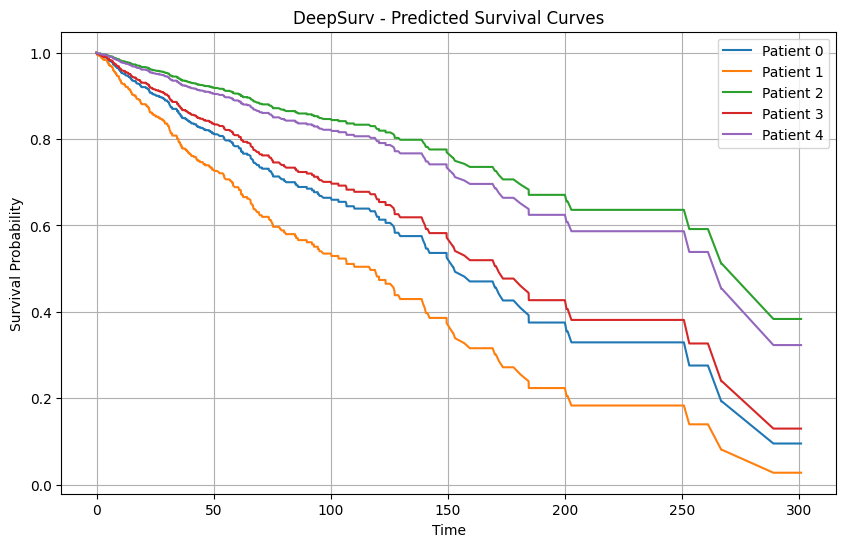

In [17]:
# ============================================
# ✅ Plot Survival Curves
# ============================================
import matplotlib.pyplot as plt

if not surv.isna().any().any():
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(surv.columns[:5]):
        plt.plot(surv.index, surv[col], label=f"Patient {i}")
    plt.title("DeepSurv - Predicted Survival Curves")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Still NaNs in survival curves. Check training loss and input scaling.")

  0%|          | 0/10 [00:00<?, ?it/s]

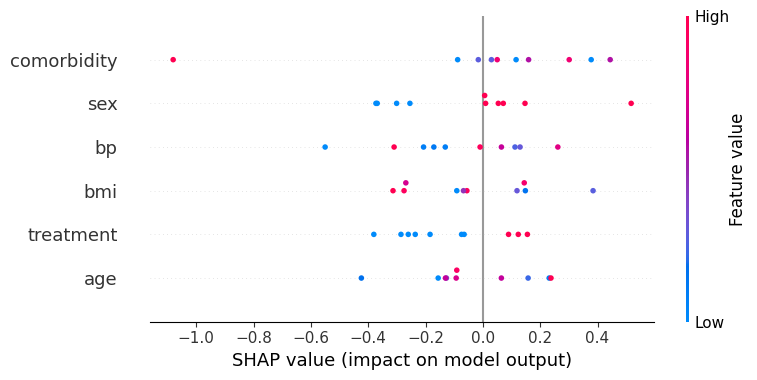

In [18]:
# ============================================
# Cell 6 — SHAP Analysis of DeepSurv Model
# ============================================
import shap
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1) Prepare clean feature matrix (drop time/event)
feature_names = [c for c in df.columns if c not in ['time','event']]
X_raw = df[feature_names].values.astype('float32')

# 2) Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X_raw)

# 3) Scale features (same as training)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp).astype('float32')

# 4) Define SHAP-compatible prediction function
def risk_fn(x):
    x = np.asarray(x, dtype='float32')
    out = model.predict(x)  # log hazard ratio
    out = np.array(out).reshape(-1)
    if not np.isfinite(out).all():
        finite = out[np.isfinite(out)]
        med = np.median(finite) if finite.size > 0 else 0.0
        out = np.where(np.isfinite(out), out, med)
    return out

# 5) Select background and sample sets
background = X_scaled[:50]   # background for SHAP
sample = X_scaled[:10]       # samples to explain

# 6) Build KernelExplainer
explainer = shap.KernelExplainer(risk_fn, background)

# 7) Compute SHAP values
shap_values = explainer.shap_values(sample, nsamples=100)

# 8) Convert to array and fix shape
shap_arr = np.asarray(shap_values, dtype='float32')
if shap_arr.ndim == 1:
    shap_arr = shap_arr.reshape(1, -1)

# 9) Plot global SHAP summary
shap.summary_plot(shap_arr, sample, feature_names=feature_names)

In [19]:
# Save trained model
model.save_model_weights("/content/drive/MyDrive/project/deepsurv_model.pt")